<a href="https://colab.research.google.com/github/MinjaeYun/practice/blob/master/WebCollect_Note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Web scraping in a nut shell** <br>
> Minjae Yun

In [ ]:
# !pip install [package name] 
import os 
import requests 
from bs4 import BeautifulSoup
import pandas as pd
import re 

##**Goals**
*   Obtain and read url page 
*   Clean and stack information into a dataframe 
*   Repeat the same tasks
*   Trials & errors

## 1. First step: get the url page and each section

In [ ]:
url = "http://securities.stanford.edu/filings-case.html?id=100120"
soup = requests.get(url) 
# or soup=requests.get("http://securities.stanford.edu/filings-case.html?id=100120")
b = BeautifulSoup(soup.text, 'lxml') 
# assign 5 sections into 5 different objects
summary = b.findAll("section", {"id":"summary"})
company = b.findAll("section", {"id":"company"})
fic = b.findAll("section", {"id":"fic"})
ref = b.findAll("section", {"id":"ref"})
other = b.findAll("section",{"id":"other"})

In [ ]:
# tables are easily pulled by pandas package but this is not recommended in this web page
tab = pd.read_html(url)
print(tab[0])

1-1. Now we have 5 different sections that might need somewhat different methods to pull the data

In [ ]:
# 1) summary: a plain text 
summary=summary[0].text

1-2. For the other four sections, we need to sort information to stack them into a dataframe <br>
See the url page

In [ ]:
# better to individually define functions when repetition is expected
def sortInfo(L):
    Output=L
    # assign empty lists for titles and actual contents
    Output_t = []
    Output_c = []
    Output_t = [re.findall(".*(?=: )",x)[0] for x in Output] # everything before ": "
    Output_c = [re.findall("(?<=: ).*",x)[0] for x in Output] # everything after ": "
    Output = pd.DataFrame(Output_c).transpose()
    # cleaning titles to work in Stata
    Output_t = [x.lower() for x in Output_t]  
    Output_t = [x.replace(" ","_") for x in Output_t] 
    Output_t = [x.replace("#","num") for x in Output_t] 
    Output.columns=Output_t
    return Output
def getTab(bs4Tag): # get table from each code chunk
    Output = []
    tabRows = bs4Tag[0].find_all('tr')
    for tr in tabRows: 
        td = tr.find_all('td')
        row = [i.text for i in td]
        Output.append(row)
    Output = [x for x in Output if x != []] # eliminate element 
    Output = pd.DataFrame(Output)
    Output = Output.set_index(0)
    return Output
def getInfo(bs4Result): # get individual info from bs4 element
    Output = []
    Output = [x.text for x in bs4Result] # convert the individual info into a list
    Output = "\n".join(Output) 
    Output = Output.split("\n")
    Output = [x for x in Output if x!='']
    Output = sortInfo(Output) # we defined sortInfo function above
    return Output

In [ ]:
# example of list operator
a = [1,2,3,4]
a = [1+x for x in a]
print(a)

In [ ]:
# 2) company: 
c_tit = company[0].findAll("p",{"class":"lead"})
c_content = company[0].findAll("div",{"class":"row-fluid"})
c = [] 
for j in range(len(c_tit)):
    c.append(c_content[j].text)
c = "\n".join(c).split("\n")
# "\n".join(LIST) joins elements in LIST
# STRING.split("\n") splits elements in STRING 
c = [x for x in c if x != ''] # get rid of empty information
c = sortInfo(c) 

In [ ]:
print("\n".join(c).split("\n")[0])

1-3. First Identified Complaint and Reference share the same structure with a little bit of more work required

In [ ]:
# 3) first identified complaint
fic_info = fic[0].findAll("div",{'class':'row-fluid'})
fic_info = getInfo(fic_info) 
# change the column names to separte from reference
cols = list(fic_info.columns)
cols = ["fic_"+x for x in cols]
fic_info.columns = cols
pltf_name = fic[0].findAll("ol",{'class':'styled'})
pltf_name = pltf_name[0].text
pltf_name = [x for x in pltf_name.split("\n") if x !='']
fic_tab = pd.DataFrame()
try: # error resistent command (sometimes there's no tab at all)
    fic_tab = fic[0].find_all("table") 
    fic_tab = getTab(fic_tab)
    # other information in the links in the table
    # click and get the information - next class
except:
    pass

In [ ]:
# 4) reference
try:
  ref_info = ref[0].findAll("div",{'class':'row-fluid'})
  ref_info = getInfo(ref_info)
  # change the column names to separte from fic
  cols = list(ref_info.columns)
  cols = ["ref_"+x for x in cols]
  ref_info.columns = cols
  pltf_name = ref[0].findAll("ol",{'class':'styled'})
  pltf_name = pltf_name[0].text
  pltf_name = [x for x in pltf_name.split("\n") if x !='']
  # court dockets are in tables
  ref_tab = pd.DataFrame()
  try:
      ref_tab = ref[0].findAll("table") 
      ref_tab = getTab(ref_tab)
      # other information in the links in the table
      # click and get the information - next class
  except: pass
except Exception as errorMessage:
    print(errorMessage)
    pass

In [ ]:
# 5) other 
# find whether it has a document section first - there are lots of missing cases
# if "Related District Court Filings Data is not available" not in soup.text:
# click and get the plain text
# if "not available" not in ref[0].text:        
# next class

In [ ]:
# convert collected information into a dataframe
df = pd.DataFrame() 
df = pd.concat([df,c], axis=1, ignore_index=True) # company information
df =pd.concat([df,fic_info],axis=1, ignore_index=True) # fic information
df =pd.concat([df,ref_info],axis=1, ignore_index=True) # reference information
df.columns = list(c.columns) + list(fic_info.columns) + list(ref_info.columns) # fix column names

In [ ]:
df.to_csv("dfname.csv", index=False, encoding="utf-8-sig")

## 2. Iteration and scraping of less structured texts
* for/while loops work sequentially
* Indentation is important

In [ ]:
for i in range(10):
  print(i)

In [ ]:
print(list(range(10)))

In [ ]:
i=0
while i < 10:
  print(i)
  i+=1
  #or equivalently i=i+1

In [ ]:
# why do we use while loop? 
i=200
while i % 2 == 0:
  print(i)
  i=i/2

In [ ]:
for j in range(10): # something we get to tentatively determine in the case of for loop
  number = 200/2**j
  if number % 2 == 0:
    print(number)

2-1. Get the libraries for adding irregularities

In [ ]:
import numpy as np
import time
print("let the computer pause for one second")
# time.sleep(1)
print(np.random.uniform(2,3,1))
print(np.random.uniform(2,3,1)[0])

In [ ]:
time.sleep(np.random.uniform(2,3,1)[0])

2-2. End goal for iteration

In [ ]:
i=0
data = pd.DataFrame()
while i < 5:
  ID=100120+i # always good to have identifiers
  url = "http://securities.stanford.edu/filings-case.html?id="+str(ID) 
  soup = requests.get(url) 
  b = BeautifulSoup(soup.text, 'lxml') 
  # designate 5 sections into 5 different variables
  summary = b.findAll("section", {"id":"summary"})
  company = b.findAll("section", {"id":"company"})
  fic = b.findAll("section", {"id":"fic"})
  ref = b.findAll("section", {"id":"ref"})
  other = b.findAll("section",{"id":"other"})

  # 1) summary is just plain text --> get the text
  summary = summary[0].text
  
  # 2) company is quite structured 
  # c_name = company[0].findAll("div",{"class":"page-header"})
  c_tit = company[0].findAll("p",{"class":"lead"})
  c_content = company[0].findAll("div",{"class":"row-fluid"})
  c = [] # contain the title and content into one list
  for j in range(len(c_tit)):
      c.append(c_content[j].text)
  c = "\n".join(c).split("\n")
  c = [x for x in c if x != '']
  c = sortInfo(c) 

  # 3) first identified complaint
  # fic_tit = fic[0].findAll("div",{'class':'page-header'})
  fic_info = fic[0].findAll("div",{'class':'row-fluid'})
  fic_info = getInfo(fic_info) 
  # change the column names to separte from reference
  cols = list(fic_info.columns)
  cols = ["fic_"+x for x in cols]
  fic_info.columns = cols
  pltf_name = fic[0].findAll("ol",{'class':'styled'})
  pltf_name = pltf_name[0].text
  pltf_name = [x for x in pltf_name.split("\n") if x !='']
      
  # 4) reference --- reuse the codes above
  # ref_tit = ref[0].findAll("div",{'class':'page-header'})
  ref_info = pd.DataFrame()
  try:
    ref_info = ref[0].findAll("div",{'class':'row-fluid'})
    ref_info = getInfo(ref_info)
    # change the column names to separte from fic
    cols = list(ref_info.columns)
    cols = ["ref_"+x for x in cols]
    ref_info.columns = cols
    pltf_name = ref[0].findAll("ol",{'class':'styled'})
    pltf_name = pltf_name[0].text
    pltf_name = [x for x in pltf_name.split("\n") if x !='']
  except: pass
  # 5) other
  final = pd.DataFrame()
  final = pd.concat([final,c], axis=1, ignore_index=True)
  final =pd.concat([final,fic_info],axis=1, ignore_index=True)
  final =pd.concat([final,ref_info],axis=1, ignore_index=True)
  final.columns = list(c.columns) + list(fic_info.columns) + list(ref_info.columns)
  final['id'] = ID # identifier
  data = pd.concat([data,final],ignore_index=True,sort=False)
  time.sleep(np.random.uniform(2,3,1)[0])
  # save in every 100 observations -- error resistant
  if i % 100==0:
    data.to_csv("dfname.csv", index=False, encoding="utf-8-sig")
  i+=1

In [ ]:
print(data.columns)

## 3. Less structured text
In thise section, we will learn how to parse information from plain text and how to save PDFs into the folder

In [ ]:
# Collect information from a plain text see example page
context = requests.get("http://securities.stanford.edu/filings-documents/1001/EEX98/001.html")
print(link)
context = BeautifulSoup(context.text, 'lxml')
context = context.text
type(context)
context = context.split("\n") # line split
type(context)

In [ ]:
# basic information 
basket = []
for element in context:
  if ("CIVIL DOCKET FOR CASE #:" in element or # identifier
        "Assigned to:" in element or # judge information 
        "Lead Docket" in element or # don't know but seems to be important
        "Dkt# in other court" in element): # another id
      basket.append(element)
print(basket)

## Regular expression
[Google for education](https://developers.google.com/edu/python/regular-expressions) <br>
[Practice page](https://regexr.com/) <br>
We can capture abstract words by using the regular expression

In [ ]:
import re
text = "take each type of chunks of characters from this string: @$%&* 18424 AZDFTFH kjiwer mail@address.com another@address.com theother@gmail.com"
re.findall("\w+", text) # chracters except for symbols
re.findall("[a-z]+", text) # only the lower letters
re.findall("[0-9]+", text) # only the numbers

In [ ]:
# sequence of actions
actions = [x for x in context if re.findall("\d+/\d+/\d{2}",x[:8])!=[]] # list 
actions = "%%%".join(actions) # string (is to be stored in the data frame later)
print(actions)

## A look into the data structure

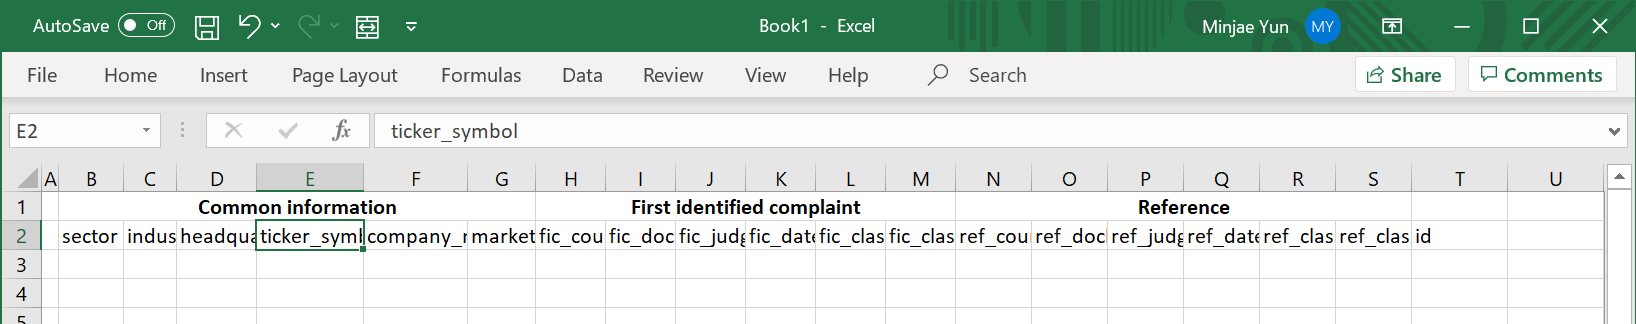

## Define functions for repetitive tasks
Rule of thumb to define a function:
* Name it with a verb
* Put less than or equal to three arguments

In [ ]:
i=0
ID = 100120 + i
filename = "fic"+str(ID)
def readHtml(T):
    Output = pd.DataFrame()
    Ds = ""
    Ls = BeautifulSoup(T, 'lxml')
    Ls = Ls.text
    Ls = Ls.split("\n")
    Ls = [x for x in Ls if x != ""]  # cleaning process
    Ds = [x for x in Ls if re.findall("\d+/\d+/\d{2}",x[:8])!=[]]
    Ds = "%%%".join(Ds)
    B = []
    for E in Ls[:15]:
        if ("CIVIL DOCKET FOR CASE #:" in E or
             "Assigned to:" in E or 
             "Lead Docket" in E or 
             "Dkt# in other court" in E):
            B.append(E)
    B = "  ".join(B) # cleaning process
    B = B.split("  ") # cleaning process 
    B = [x for x in B if x != ""] # cleaning process
    B = sortInfo(B)
    Output = B
    Output['dockets'] = Ds
    return Output
# not the most beautiful function
def getDocket(Input,U,Filename,Order): # Input examples: fic, ref, other    
    Output = pd.DataFrame()
    Link = U
    t = Input.findAll("tr",{"class":"table-link"})
    L = Link+re.findall("'(.*)'", t[Order]['onclick'])[0]
    R = requests.get(L)
    if ".pdf" in L: 
        with open(Filename+"_"+str(Order), 'wb') as f: # save file when it's pdf
            f.write(R.content) # .read is to load file
        Output = pd.DataFrame(["pdf"])
    elif ".html" in L: # elif for multiple conditional statements
        docket = readHtml(R.text)
        Output = docket
    return Output
def eachDoc(Input, U, Filename, Order, Tab):
    Output = getDocket(Input, U, Filename, Order)
    if Output.iloc[0,0] != "pdf":
        Output['document'] = Tab[1].values[Order]
        Output['filing_date'] = Tab[2].values[Order]
        Output.columns = [x+str(Order) for x in list(Output)]
    return Output

In [ ]:
# section 3 first identified complaint
fic_info = fic[0].findAll("div",{'class':'row-fluid'})
fic_info = getInfo(fic_info) 
# change the column names to separte from reference
cols = list(fic_info.columns)
cols = ["fic_"+x for x in cols]
fic_info.columns = cols
pltf_name = fic[0].findAll("ol",{'class':'styled'})
pltf_name = pltf_name[0].text
pltf_name = [x for x in pltf_name.split("\n") if x !='']
fic_tab = pd.DataFrame()
link = 'http://securities.stanford.edu/' 
cols = ["document", "filing_date"]
try: # sometimes there's no tab at all
    fic_tab = fic[0].find_all("table") 
    fic_tab = getTab(fic_tab).reset_index(drop=True) # drop the previous index
    filename = "fic"+str(ID) # save file name
    htmls = pd.DataFrame() # we will stack information in this Pandas container
    for j in range(len(fic_tab)):
        mid_step = eachDoc(fic[0], link, filename, j, fic_tab)
        if mid_step.iloc[0,0] != "pdf": # conditional statement
          htmls = pd.concat([htmls,mid_step],axis=1)
    htmls.columns = ["fic"+x for x in list(htmls)]
    # we might want to store it into one cell
    cols_to_store = list(htmls)
    cols_to_store = "###".join(cols_to_store)
    htmls['fic_html'] = "###".join(list(htmls.iloc[0]))
    htmls['fic_cols'] = cols_to_store    
    fic_info = pd.concat([fic_info, htmls[['fic_html','fic_cols']]],axis=1)
except:
    pass
# section 4 reference
ref_tab = pd.DataFrame()
try:
    ref_tab = ref[0].findAll("table") 
    ref_tab = getTab(ref_tab).reset_index(drop=True)
    filename = "ref"+str(ID)
    htmls = pd.DataFrame()
    for j in range(len(ref_tab)):
        mid_step = eachDoc(ref[0], link, filename, j, ref_tab)
        if mid_step.iloc[0,0] != "pdf":
            htmls = pd.concat([htmls,mid_step],axis=1)
    htmls.columns = ["ref"+x for x in list(htmls)]
    # we might want to store it into one cell
    cols_to_store = list(htmls)
    cols_to_store = "###".join(cols_to_store)
    htmls['ref_html'] = "###".join(list(htmls.iloc[0]))
    htmls['ref_cols'] = cols_to_store
    ref_info = pd.concat([ref_info, htmls[['ref_html','ref_cols']]],axis=1)
except: pass

In [ ]:
# section 5 other information
related = pd.DataFrame()
if "Related District Court Filings Data is not available" in soup.text:
    pass
else:
    other_tab = other[0].findAll("table")
    other_tab = getTab(other_tab).reset_index(drop=True)
    filename = "related"+str(ID)
    htmls = pd.DataFrame()
    for j in range(len(other_tab)):
        mid_step = eachDoc(other[0], link, filename, j, other_tab)
        if mid_step.iloc[0,0] != "pdf":
          htmls = pd.concat([htmls,mid_step],axis=1)
    htmls.columns = ["related_"+x for x in list(htmls)]
    cols_to_store = list(htmls)
    cols_to_store = "###".join(cols_to_store)
    htmls['related_html'] = "###".join(list(htmls.iloc[0]))
    htmls['related_cols'] = cols_to_store
    ref_info = pd.concat([ref_info, htmls[['related_html','related_cols']]],axis=1)

## 4. Selenium for navigating through the page
Introduction [link](https://selenium-python.readthedocs.io/installation.html) <br>
Download Firefox browser interface program [link](https://github.com/mozilla/geckodriver/releases)

In [ ]:
!pip install selenium
from selenium.webdriver import Firefox, FirefoxProfile
# from selenium.webdriver.common.action_chains import ActionChains # put several actions into one code
# from selenium.webdriver.support import expected_conditions as EC # conditionally run a code
# from selenium.webdriver.support.wait import WebDriverWait # letting the program wait
# from selenium.webdriver.common.by import By # specify what kind of syntax we use from the web page

In [ ]:
# set up the directory so that the program can know where to pull out the browser
root_directory = "C:\\downloads"
driver = Firefox(executable_path=root_directory+'/geckodriver')

In [ ]:
# navigate through page
driver.get("http://securities.stanford.edu/filings.html")
go = driver.find_element_by_xpath('//*[@id="records"]/table/tbody/tr[1]/td[1]')
'//*[@id="records"]/table/tbody/tr[1]/td[1]'
'//*[@id="records"]/table/tbody/tr[2]/td[1]'
'//*[@id="records"]/table/tbody/tr[20]/td[1]'
i = 0
while i < 21:
  xpath = '//*[@id="records"]/table/tbody/tr['+str(i)+']/td[1]'
  go = driver.find_element_by_xpath(xpath)
  go.click()
  i+=1

In [ ]:
# get the content
html = driver.page_source
b = BeautifulSoup(html, 'lxml')

In [ ]:
# get to the next page
# 1) mannually click the page 
go = driver.find_element_by_xpath('//*[@id="records"]/div[2]/ul/li[3]/a')
go.click()
# 2) we can iterate the link again
i=2
while i < 10:
  link = "http://securities.stanford.edu/filings.html?page="+str(i)
  driver.get(link)
